In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin, clone

In [6]:
# 1. Simulate time-series dataset
def generate_time_series(n=1000, seed=42):
    np.random.seed(seed)
    t = np.arange(n)
    y = np.sin(t / 50) + np.random.normal(0, 0.2, size=n)
    df = pd.DataFrame({"timestamp": pd.date_range("2020-01-01", periods=n, freq="D"), "target": y})
    return df

df = generate_time_series()

In [7]:
# 2. Feature engineering: lag features + rolling mean
class LagFeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self, lags=[1, 3, 7], rolling_windows=[3, 7]):
        self.lags = lags
        self.rolling_windows = rolling_windows

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for lag in self.lags:
            X[f"lag_{lag}"] = X["target"].shift(lag)
        for win in self.rolling_windows:
            X[f"rollmean_{win}"] = X["target"].shift(1).rolling(window=win).mean()
        return X.dropna().reset_index(drop=True)

In [8]:
# 3. Time-Aware CV with compatibility
def chrono_train_val_split(df, val_size):
    """Split time-series into train and validation with time order preserved"""
    split_idx = int(len(df) * (1 - val_size))
    return df.iloc[:split_idx], df.iloc[split_idx:]


In [9]:
# 4. Prepare data
df_fe = LagFeatureAdder().transform(df)
features = [col for col in df_fe.columns if col.startswith("lag_") or col.startswith("rollmean_")]
target = "target"

X = df_fe[features]
y = df_fe[target]

In [10]:
# 5. Define pipeline
pipe = Pipeline([
    ("imputer", SimpleImputer()),
    ("scaler", StandardScaler()),
    ("model", Ridge())
])

In [11]:
# 6. Custom TimeSeriesSplit for CV
tscv = TimeSeriesSplit(n_splits=5)

In [12]:
# 7. Grid search
param_grid = {
    "model__alpha": [0.1, 1.0, 10.0]
}
grid = GridSearchCV(pipe, param_grid, cv=tscv, scoring="neg_mean_squared_error", n_jobs=-1)
grid.fit(X, y)

print(f"Best alpha: {grid.best_params_['model__alpha']}")

Best alpha: 1.0


In [13]:
# 8. Evaluate on hold-out
train_df, val_df = chrono_train_val_split(df_fe, val_size=0.1)
X_train, y_train = train_df[features], train_df[target]
X_val, y_val = val_df[features], val_df[target]

model = clone(grid.best_estimator_)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

metrics = {
    "MAE": mean_absolute_error(y_val, y_pred),
    "MSE": mean_squared_error(y_val, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_val, y_pred)),
    "R2": r2_score(y_val, y_pred)
}
print("\nHold-out metrics:")
print(json.dumps(metrics, indent=2))


Hold-out metrics:
{
  "MAE": 0.1656160231982433,
  "MSE": 0.04448917945627069,
  "RMSE": 0.21092458238970319,
  "R2": 0.8421532540898136
}


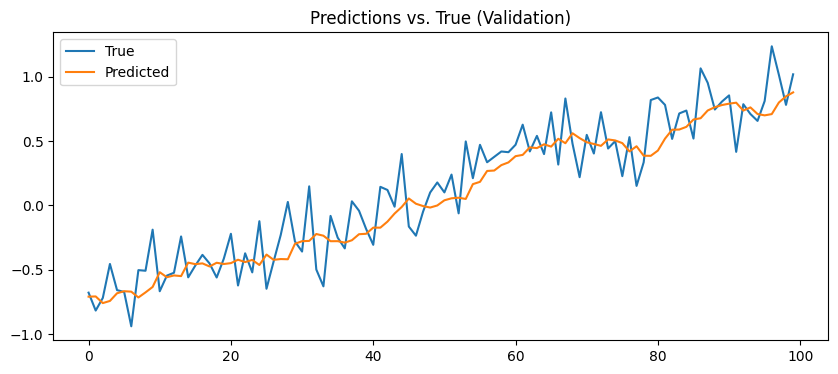

In [14]:
# 9. Plot predictions
plt.figure(figsize=(10, 4))
plt.plot(y_val.values, label="True")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("Predictions vs. True (Validation)")
plt.show()


Core Ideas Addressed in ChronoLearn:

Lag-based feature engineering to capture temporal dependencies in time-series regression.

Time-aware cross-validation using TimeSeriesSplit to avoid temporal leakage.

Pipeline compatibility for reproducibility and integration with model selection tools.

🔬 Key Academic Papers Supporting These Ideas:
1. Time Series Feature Engineering

Christ, M., Braun, N., Neuffer, J., & Kempa-Liehr, A. W. (2018).
"Time Series FeatuRe Extraction on basis of Scalable Hypothesis tests (tsfresh – A Python package)"
Neurocomputing, 307, 72–77.
📌 Relevance: Highlights the importance of automated feature extraction from time series (e.g., lags, rolling stats) to improve predictive performance.
🔗 https://doi.org/10.1016/j.neucom.2018.03.067

2. Avoiding Temporal Leakage in Model Evaluation

Bergmeir, C., & Benítez, J. M. (2012).
"On the use of cross-validation for time series predictor evaluation"
Information Sciences, 191, 192–213.
📌 Relevance: Critiques the use of random k-fold CV for time-series and advocates for time-aware cross-validation like TimeSeriesSplit to maintain chronological integrity.
🔗 https://doi.org/10.1016/j.ins.2011.12.028

3. Time Series Cross-Validation in Practice

Hyndman, R. J., & Athanasopoulos, G. (2018).
"Forecasting: Principles and Practice" (2nd ed.)
📌 Relevance: This open-access book is widely cited and explains rolling-origin evaluation, analogous to TimeSeriesSplit, and emphasizes lag-based modeling in forecasting.
🔗 https://otexts.com/fpp2/

✅ Summary Statement

ChronoLearn follows established best practices in the time-series modeling literature by combining lag-based features and time-aware cross-validation, ensuring that temporal dependencies are captured without introducing leakage or bias — as emphasized in the works of Bergmeir et al. (2012) and Hyndman (2018).